# First Steps in accessing Satellite Imagery on Copernicus Data Space Ecosystem with Sentinel Hub APIs

The Sentinel Hub API is a RESTful API interface that provides access to various satellite imagery archives. It allows you to access raw satellite data, rendered images, statistical analysis, and other features.

In [157]:
# Utilities
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime
#import pandas as pd
import getpass
import geopandas as gpd
import rasterio
import rasterio.plot
import numpy as np

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
)



### Credentials

To obtain your `client_id` & `client_secret`, you need to navigate to your [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/). In the User Settings, you can create a new OAuth client to generate these credentials. More detailed instructions can be found on the corresponding [documentation page](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html).

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). Following these instructions, you can create a profile specifically for using the package to access Copernicus Data Space Ecosystem data collections. This is useful as changes to the config class in your notebook are usually only temporary and by saving the configuration to your profile, you don't have to generate new credentials or overwrite/change the default profile every time you run or write a new Jupyter Notebook. 

If you are using the Sentinel Hub Python package for the Copernicus Data Space Ecosystem for the first time, you should create a profile specifically for the Copernicus Data Space Ecosystem. You can do this in the following cell:

In [158]:
# Only run this cell if you have not created a configuration.

config = SHConfig()
config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save("cdse")

Enter your SentinelHub client id ········
Enter your SentinelHub client secret ········


However, if you have already configured a profile in Sentinel Hub Python for the Copernicus Data Space Ecosystem, then you can run the below cell entering the profile name as a string replacing `profile_name`.

In [159]:
#config = SHConfig("cdse")

## Area of Interest 

S.

In [160]:
# Desired resolution of our data
resolution = (1000, 1000)
bbox_coords = [28.566742,40.820321,29.408569,41.337654]
epsg = 3035
# Convert to 3035 to get crs with meters as units
bbox = BBox(bbox_coords, CRS(4326)).transform(epsg)

## Data Access

Next, we define our [evalscript](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript.html). The evalscript is a piece of JavaScript code that tells the Copernicus Dataspace Ecosystem how to process the pixels you request before they are delivered to you.

In [161]:
# We also need to define the evalscript as a Python variable
evalscript_raw = """
//VERSION=3
function setup() {
   return {
    input: ["F1"], // This specifies the bands that are looked at
    output: { 
      bands: 1,
      // This specifies in which data type the values will be returned
      sampleType: "UINT16"
    },
    // Will make a simple mosaic, taking the most recent tiles to fill the bounding box
    mosaicking: "SIMPLE"
  };
}

function evaluatePixel(samples) {
    // Here we could do more calculations which are applied to each pixel, 
    // but for now let's just return the value 
   return [samples.F1-273] //Returns values in K
}
"""

In [162]:
def plot_request(request, bbox):
    image_path = Path(request.data_folder) / request.get_filename_list()[0]
    with rasterio.open(image_path) as raster:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xlim([bbox.min_x, bbox.max_x])
        ax.set_ylim([bbox.min_y, bbox.max_y])
        
        # Show the raster image with its original colors
        raster_data = raster.read()
        rasterio.plot.show(raster, ax=ax, transform=raster.transform, adjust='linear')

        # Overlay the country boundaries
        countries.plot(ax=ax, facecolor="none", edgecolor="black")
        
        # Add a colorbar for the raster image
        cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical')
        cbar.set_label('Color Scale')

        plt.show()

# Assuming countries is a GeoDataFrame with country boundaries
# Assuming bbox is an object with min_x, max_x, min_y, max_y attributes

In [163]:
# This is defining the data we will use.
# You can list all available data collections with `DataCollection.get_available_collections()`.
data_l8 = DataCollection.SENTINEL3_SLSTR.define_from(name="s3slstr", service_url=config.sh_base_url)

request_raw = SentinelHubRequest(
    evalscript=evalscript_raw,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=data_l8,
            time_interval=("2023-06-09", "2024-06-09"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox,
    # Resolution is defined in units of the bbox crs! Be careful with WGS84 since this will be in degrees!
    # Since we have defined our bounding box in Web mercator the resolution is in meters.
    resolution=resolution, #It was already defined
    config=config,
    data_folder="./data",  # We save the data in a specified folder
)

In [164]:
raw_data = request_raw.get_data(save_data=True)

In [165]:
countries = (
    gpd.read_file("./data/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp")
    .to_crs(3035)
    .cx[bbox.min_x : bbox.max_x, bbox.min_y : bbox.max_y]
    .reset_index(drop=True)
)
countries = countries[["ADMIN", "geometry"]]


def plot_request(request, bbox):
    image_path = Path(request.data_folder) / request.get_filename_list()[0]
    with rasterio.open(image_path) as raster:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xlim([bbox.min_x, bbox.max_x])
        ax.set_ylim([bbox.min_y, bbox.max_y])
        rasterio.plot.show(raster, ax=ax)
        countries.plot(ax=ax, facecolor="none", edgecolor="black")
        cbar = plt.colorbar(rasterio.plot.show(raster, ax=ax).get_images()[0], ax=ax, orientation='vertical')
        cbar.set_label('Celsius')

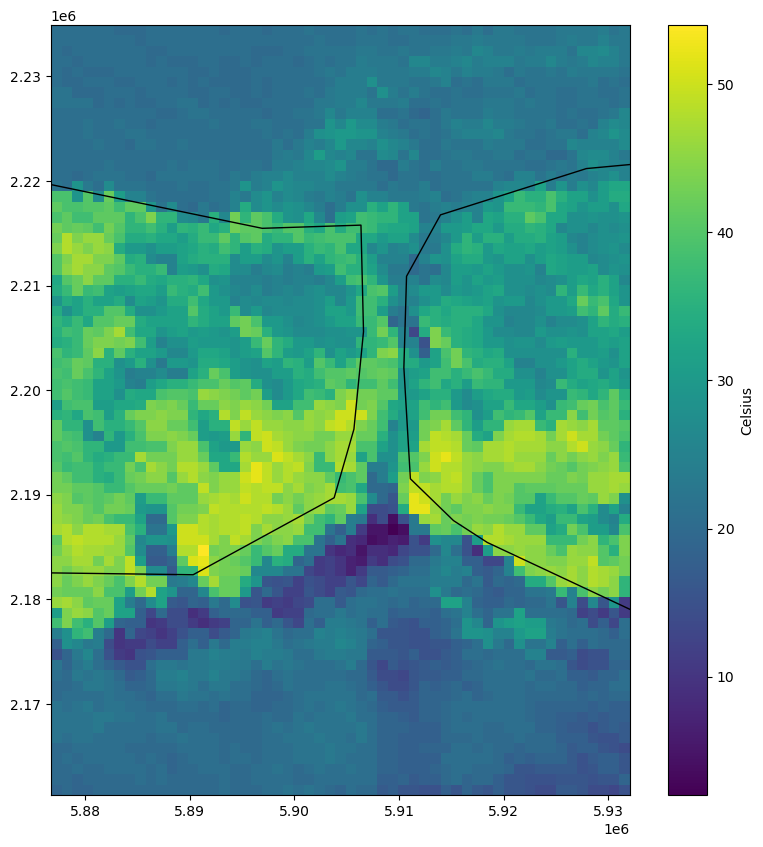

In [166]:
plot_request(request_raw, bbox)

# Obtaining statistics with statistical API

In [172]:
evalscript_mean_mosaic = """
//VERSION=3
function setup() {
    return {
        input: ["F1", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
        },
        mosaicking: "ORBIT"
    };
}

function isClear(sample) {
    return sample.dataMask == 1;
}

function sum(array) {
    let sum = 0;
    for (let i = 0; i < array.length; i++) {
        sum += array[i].F1; //Reduce 273 from F1 value
    }
    return sum;
}

function evaluatePixel(samples) {
    const clearTs = samples.filter(isClear)
    const mean = sum(clearTs) / clearTs.length
    return [mean-273]
}
"""

In [186]:
request_monthly = SentinelHubRequest(
    evalscript=evalscript_mean_mosaic,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=data_l8,
            time_interval=("2023-07-01", "2023-08-01"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox,
    resolution=(1000, 1000),
    config=config,
    data_folder="./data",
)

In [187]:
mean_data = request_monthly.get_data(save_data=True)

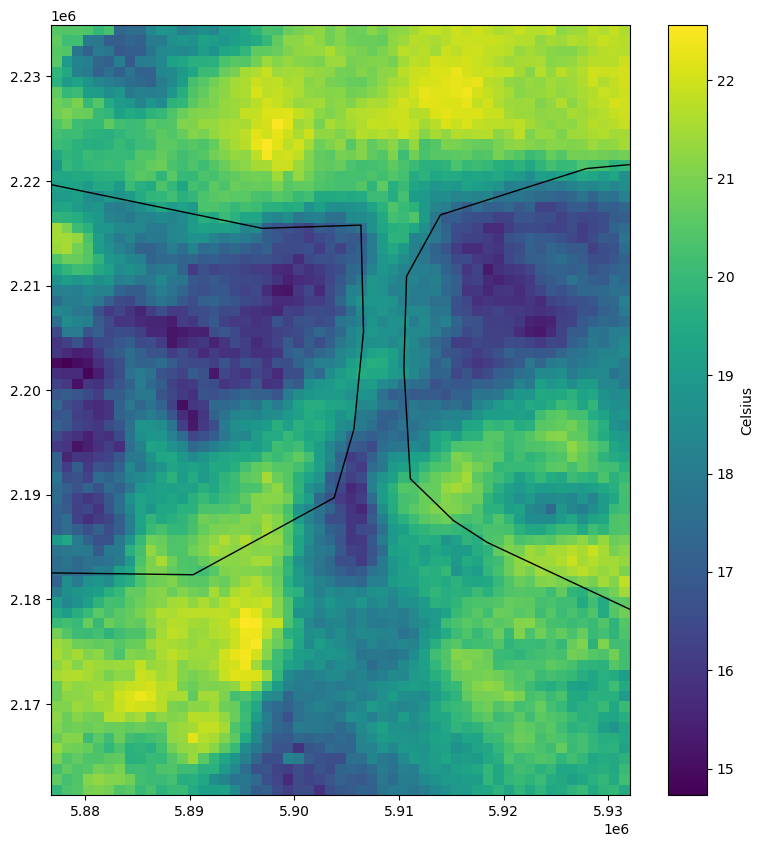

In [188]:
plot_request(request_monthly, bbox)

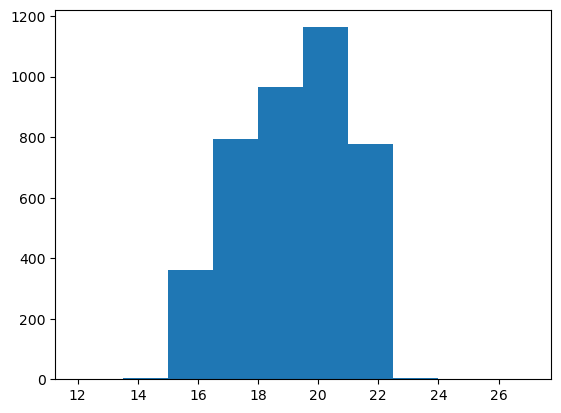

In [191]:
plt.stairs(*np.histogram(mean_data[0], range=(12, 27), bins=10), fill=True);

## Import Global Human Settlement collection
Copernicus Data Space Ecosystem allows users to upload their own data in a [Cloud Optimized Geotiff (COG)](https://www.cogeo.org/) format, ingesting it with the [Bring Your Own COG ("BYOC") API](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Byoc.html). Once a dataset is ingested, in can be made available privately or publicly, and other Sentinel Hub API requests can access the data collection via its BYOC collection ID ([example here](https://github.com/eu-cdse/notebook-samples/blob/main/sentinelhub/cloudless_process_api.ipynb))

In [177]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["GHS_BUILT_S", "dataMask"],
    output: { bands: 1, sampleType: "UINT16" },
  };
}

function evaluatePixel(samples) {
  return [samples.GHS_BUILT_S];
}
"""

In [178]:
time_interval=("2010-01-01", "2010-01-02")
bbox_coords = [28.566742,40.820321,29.408569,41.337654]
epsg = 3035
# Convert to 3035 to get crs with meters as units
bbox = BBox(bbox_coords, CRS(4326)).transform(epsg)

In [183]:
ghs_collection = DataCollection.define_byoc(
    "379e04b9-c6cf-4561-b9e9-291ea1aa4c2c", service_url=config.sh_base_url
)
ghs_request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=ghs_collection,
            time_interval=time_interval,
         #   mosaicking_order=MosaickingOrder.MOST_RECENT,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox,
    resolution=(400,400),
    config=config,
    data_folder="./data",
)

In [184]:
human_settlement = ghs_request.get_data(save_data=True)[0]

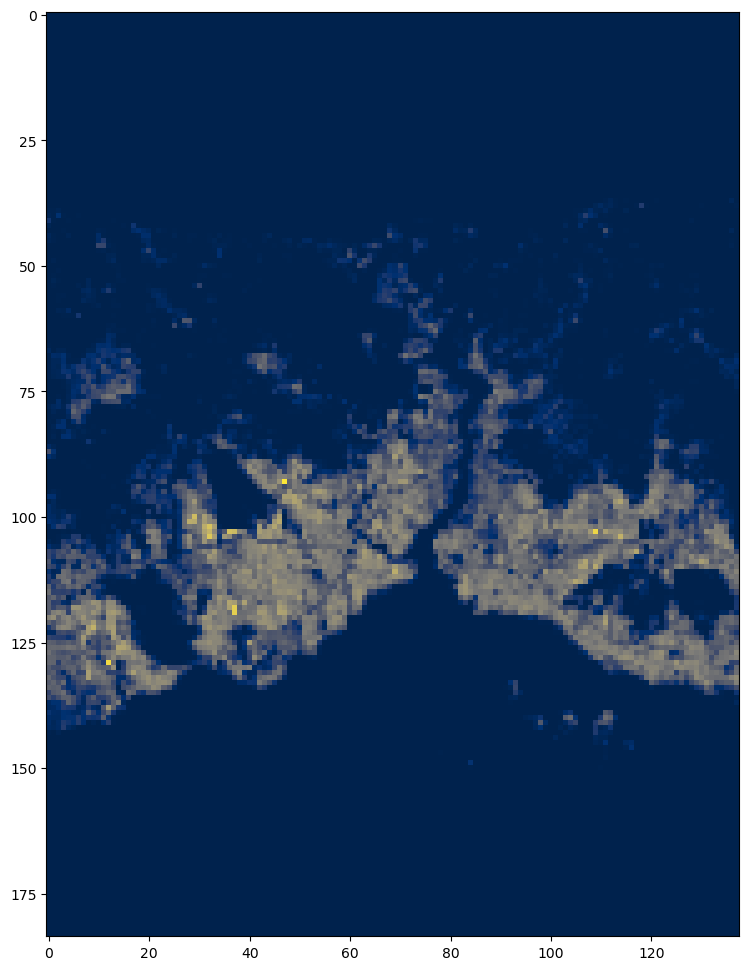

In [185]:
plt.figure(figsize=(12, 12))
plt.imshow(human_settlement, cmap="cividis");